In [549]:
# import libraries
import time
import calendar
import numpy as np
import pandas as pd
from dateutil.parser import parse
from datetime import date, timedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

import os

%matplotlib inline


In [550]:
data_dir = "data/"
air_visit = pd.read_csv(data_dir + "air_visit_data.csv")
air_reserve = pd.read_csv(data_dir + "air_reserve.csv")
hpg_reserve = pd.read_csv(data_dir + "hpg_reserve.csv")
air_store  = pd.read_csv(data_dir + "air_store_info.csv")
hpg_store = pd.read_csv(data_dir + "hpg_store_info.csv")
date_info = pd.read_csv(data_dir + "date_info.csv")
store_id_map  = pd.read_csv(data_dir + "store_id_relation.csv")
submission = pd.read_csv(data_dir + "sample_submission.csv")

In [551]:
# define utility funtions
def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_error(y_test, y_pred))

calendar.setfirstweekday(6)

def get_week_of_month(date_str):
    year = int(date_str[:4])
    month = int(date_str[5:7])
    day = int(date_str[8:10])
    x = np.array(calendar.monthcalendar(year, month))
    week_of_month = np.where(x==day)[0][0] + 1
    return(week_of_month)

In [552]:
print(len(air_visit))
air_visit.head()

252108


,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


Combine Train and Test data ( test data has 0 as output ) - Need to predict that.
We will separate later

In [553]:
air_visit_count = len(air_visit)

train_data = air_visit.copy()
test_data = submission.copy()

test_data["air_store_id"] = test_data.apply(lambda x: '_'.join(x['id'].split('_')[:2]), axis=1)
test_data["visit_date"] = test_data.apply(lambda x:x['id'].split("_")[-1], axis=1)
test_data.drop("id",axis=1, inplace=True)

concat_data = pd.concat([train_data, test_data])
concat_data.head(1)

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25


In [554]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


Combine Date-Information with the data ( that gives information about day of the week and if its holiday or not)

In [555]:
concat_data = pd.merge(concat_data, date_info, how="left", left_on="visit_date", right_on="calendar_date")
concat_data.drop("calendar_date", axis=1, inplace=True)
concat_data.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0


In [556]:
hpg_store.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


Combine with hpg_store, air_store, and store_id_map.

This gives more nformation about restaurant i.e. genre, area_name, latitude, longitude

In [557]:
concat_data = pd.merge(concat_data, air_store, how="left", on="air_store_id")
concat_data = pd.merge(concat_data, store_id_map, how="left", on="air_store_id")
concat_data = pd.merge(concat_data, hpg_store, how="left", on="hpg_store_id")
concat_data.head()

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,Thursday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,Friday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
3,air_ba937bf13d40fb24,2016-01-16,22,Saturday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN
4,air_ba937bf13d40fb24,2016-01-18,6,Monday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN


# Reservation Data

In [558]:
air_reserve

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5
...,...,...,...,...
92373,air_db4b38ebe7a7ceff,2017-05-29 18:00:00,2017-04-17 19:00:00,6
92374,air_1033310359ceeac1,2017-05-30 23:00:00,2017-04-19 17:00:00,8
92375,air_877f79706adbfb06,2017-05-31 20:00:00,2017-04-12 23:00:00,3
92376,air_900d755ebd2f7bbd,2017-05-31 20:00:00,2017-04-19 16:00:00,10


In [559]:
air_reserve_data = air_reserve.copy()

# get only the date
air_reserve_data["visit_datetime"] = air_reserve_data["visit_datetime"].str[:10]
air_reserve_data.head(1)

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01,2016-01-01 16:00:00,1


In [560]:
air_reserve_data = air_reserve_data[["air_store_id", "visit_datetime", "reserve_visitors"]] \
                        .groupby(by=["air_store_id", 'visit_datetime']) \
                        .sum() \
                        .reset_index()

# Group according to air_store_id and visit_date
air_reserve_data.head(1)

,air_store_id,visit_datetime,reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,2


In [561]:
air_reserve_data = air_reserve_data.rename(columns = {'reserve_visitors': 'air_reserve_visitors'})
air_reserve_data = air_reserve_data.rename(columns = {'visit_datetime': 'visit_date'})

# Merge with original data
pd.merge(concat_data, air_reserve_data, how="left", on=['air_store_id', 'visit_date'])
air_reserve_data.head()

,air_store_id,visit_date,air_reserve_visitors
0,air_00a91d42b08b08d9,2016-10-31,2
1,air_00a91d42b08b08d9,2016-12-05,9
2,air_00a91d42b08b08d9,2016-12-14,18
3,air_00a91d42b08b08d9,2016-12-17,2
4,air_00a91d42b08b08d9,2016-12-20,4


In [562]:
concat_data = pd.merge(concat_data, air_reserve_data, how="left", on=['air_store_id', 'visit_date'])

In [563]:
concat_data.head(1)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,air_reserve_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN


In [564]:
# Same technique for HPG reserve also 
hpg_reserve_data = hpg_reserve.copy()
hpg_reserve_data["visit_datetime"] = hpg_reserve_data["visit_datetime"].str[:10]
hpg_reserve_data = hpg_reserve_data[["hpg_store_id", "visit_datetime", "reserve_visitors"]] \
                        .groupby(by=["hpg_store_id", 'visit_datetime']) \
                        .sum() \
                        .reset_index()
hpg_reserve_data = hpg_reserve_data.rename(columns = {'reserve_visitors': 'hpg_reserve_visitors'})
hpg_reserve_data = hpg_reserve_data.rename(columns = {'visit_datetime': 'visit_date'})
hpg_reserve_data["visit_date"] = hpg_reserve_data["visit_date"].str[:10]

concat_data = pd.merge(concat_data, hpg_reserve_data, how="left", on=['hpg_store_id', 'visit_date'])


In [565]:
concat_data.head(1)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,hpg_genre_name,hpg_area_name,latitude_y,longitude_y,air_reserve_visitors,hpg_reserve_visitors
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [566]:
# remove un-wanted columns ( mosly null because of join)
concat_data = concat_data.drop(["hpg_area_name", "hpg_genre_name", "latitude_y", "longitude_y"], axis=1)

The columns 

- air_store_id, 
- visit_date, 
- day_of_week, 
- air_genre_name, 
and 
- air_area_name are in a data type that cannot be operated on.

In [567]:
# dayofweek : monday(0)~sunday(6)
# Convert to pandas date-time

concat_data['visit_date'] = pd.to_datetime(concat_data['visit_date'])
concat_data['visit_day_of_week'] = pd.to_datetime(concat_data['visit_date']).dt.dayofweek
concat_data['day'] = concat_data['visit_date'].dt.day
concat_data['dow'] = concat_data['visit_date'].dt.weekday # monday:0, sunday:6
concat_data['year'] = concat_data['visit_date'].dt.year
concat_data['month'] = concat_data['visit_date'].dt.month
concat_data['week'] = concat_data['visit_date'].dt.week
concat_data['quarter'] = concat_data['visit_date'].dt.quarter
concat_data['visit_date'] = concat_data['visit_date'].dt.date

/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_43034/3034609359.py:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  concat_data['week'] = concat_data['visit_date'].dt.week


In [568]:
concat_data.head(1)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,visit_day_of_week,day,dow,year,month,week,quarter
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,2,13,2,2016,1,2,1


In [569]:
# Add weekend data - Useful as there would be more people in weekends.
concat_data['weekend_flg'] = ((concat_data['visit_day_of_week']>4)).astype(int)

In [570]:
concat_data.head(1)

,air_store_id,visit_date,visitors,day_of_week,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,visit_day_of_week,day,dow,year,month,week,quarter,weekend_flg
0,air_ba937bf13d40fb24,2016-01-13,25,Wednesday,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,2,13,2,2016,1,2,1,0


In [571]:
# Due to the nature of Japanese holidays (Happy Monday), data on the week of the month is added.
concat_data["visit_week_of_month"] = concat_data["visit_date"].apply(str).apply(get_week_of_month)

In [572]:
# One-hot encoding the day of the week
concat_data = pd.get_dummies(concat_data, columns = ['day_of_week'], prefix="", prefix_sep='')

In [573]:
concat_data.head(1)

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,quarter,weekend_flg,visit_week_of_month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,1,0,3,0,0,0,0,0,0,1


In [574]:
# Add column for days off regardless of weekend/holiday
concat_data['off_day_flg'] = ((concat_data['weekend_flg']==1) | (concat_data['holiday_flg']==1)).astype(int)

In [575]:
concat_data.head(1)

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,weekend_flg,visit_week_of_month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,off_day_flg
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0,3,0,0,0,0,0,0,1,0


In [576]:
# Add a column to determine if the next day is a holiday
concat_data['next_day_is_off'] = concat_data['off_day_flg'].shift(-1,fill_value=0).astype(int)

In [577]:
concat_data.head(1)

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,visit_week_of_month,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,off_day_flg,next_day_is_off
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,3,0,0,0,0,0,0,1,0,0


Golden Week, Japanese Ōgon Shūkan, also called Ōgata Renkyū, 
series of four holidays closely spaced together and observed at the 
end of April and beginning of May in Japan. The four holidays are Shōwa Day (April 29),
Constitution Day (May 3), Greenery Day (May 4), and Children's Day (May 5).

- From kaggle answers

In [578]:
# Add Golden Week flag
# 2016 Golden Week is from 4/29 to 5/5
# 2017 Golden Week is from 4/29 to 5/5



concat_data['golden_week_flg'] = ( \
                                  ((concat_data['visit_date'].apply(str)>='2016-04-29') & (concat_data['visit_date'].apply(str)<='2016-05-05')) | \
                                  ((concat_data['visit_date'].apply(str)>='2017-04-29') & (concat_data['visit_date'].apply(str)<='2017-05-05'))
                                 ).astype(int)

concat_data.head(1)

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,off_day_flg,next_day_is_off,golden_week_flg
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0,0,0,0,0,0,1,0,0,0


In [579]:
test_data.head()

,visitors,air_store_id,visit_date
0,0,air_00a91d42b08b08d9,2017-04-23
1,0,air_00a91d42b08b08d9,2017-04-24
2,0,air_00a91d42b08b08d9,2017-04-25
3,0,air_00a91d42b08b08d9,2017-04-26
4,0,air_00a91d42b08b08d9,2017-04-27


In [580]:
#extract unique stores id from test data
unique_stores = test_data['air_store_id'].unique()

In [581]:
# Add daily visitor statistics for each store as a feature

store_7days = pd.concat([pd.DataFrame({'air_store_id': unique_stores, 'dow': [i]*len(unique_stores)}) 
                    for i in range(7)], axis=0, ignore_index=True).reset_index(drop=True)
store_7days.tail()

,air_store_id,dow
5742,air_fea5dc9594450608,6
5743,air_fee8dcf4d619598e,6
5744,air_fef9ccb3ba0da2f7,6
5745,air_ffcc2d5087e1b476,6
5746,air_fff68b929994bfbd,6


In [582]:
store_sum = pd.DataFrame({'air_store_id': unique_stores})

In [583]:
# Add total visitors count as feature
tmp = concat_data.groupby(['air_store_id'], as_index=False)[
    'visitors'].sum().rename(columns={'visitors':'total_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id']) 

# Add Mean visitors count as feature 
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].mean().rename(columns={'visitors':'mean_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

# Add Median visitors count as feature 
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].median().rename(columns={'visitors':'median_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

# Add Max visitors count as feature 
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].max().rename(columns={'visitors':'max_visitors'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow'])

# Add count(frequency) visitors count as feature 
tmp = concat_data.groupby(['air_store_id','dow'], as_index=False)[
    'visitors'].count().rename(columns={'visitors':'count_observations'})
store_7days = pd.merge(store_7days, tmp, how='left', on=['air_store_id','dow']) 

# store_7days
# concat_data
concat_data = pd.merge(concat_data, store_7days, how='left', on=['air_store_id','dow'])

concat_data["total_visitors"] = concat_data["total_visitors"].fillna(0)
concat_data["mean_visitors"] = concat_data["mean_visitors"].fillna(0)
concat_data["median_visitors"] = concat_data["median_visitors"].fillna(0)
concat_data["max_visitors"] = concat_data["max_visitors"].fillna(0)
concat_data["count_observations"] = concat_data["count_observations"].fillna(0)

In [584]:
concat_data.head(1)

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,Tuesday,Wednesday,off_day_flg,next_day_is_off,golden_week_flg,total_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,0,1,0,0,0,8908.0,21.8,24.0,57.0,70.0


In [585]:
qoq= concat_data.groupby(['air_store_id','year','quarter'])['visitors'].sum()
qoq=qoq.unstack(0)
qoq=pd.DataFrame(qoq.to_records())
qoq=qoq.transpose()
qoq.drop(['year','quarter'],inplace=True)

# Calcualte Quarter grown with respect to previosu quarter
qoq['2016Q2']=qoq[1]/qoq[0]*100
qoq['2016Q3']=qoq[2]/qoq[1]*100
qoq['2016Q4']=qoq[3]/qoq[2]*100
qoq['2017Q1']=qoq[4]/qoq[3]*100
qoq

,0,1,2,3,4,5,2016Q2,2016Q3,2016Q4,2017Q1
air_00a91d42b08b08d9,NaN,NaN,1780.0,1740.0,2041.0,490.0,NaN,NaN,97.752809,117.298851
air_0164b9927d20bcc3,NaN,NaN,NaN,627.0,593.0,158.0,NaN,NaN,NaN,94.577352
air_0241aa3964b7f861,851.0,815.0,713.0,778.0,587.0,175.0,95.769683,87.484663,109.116410,75.449871
air_0328696196e46f18,NaN,NaN,306.0,131.0,375.0,109.0,NaN,NaN,42.810458,286.259542
air_034a3d5b40d5b1b1,NaN,NaN,905.0,732.0,1592.0,493.0,NaN,NaN,80.883978,217.486339
...,...,...,...,...,...,...,...,...,...,...
air_fea5dc9594450608,NaN,NaN,1128.0,1216.0,1268.0,357.0,NaN,NaN,107.801418,104.276316
air_fee8dcf4d619598e,NaN,NaN,2522.0,2159.0,2227.0,588.0,NaN,NaN,85.606661,103.149606
air_fef9ccb3ba0da2f7,NaN,NaN,918.0,775.0,485.0,179.0,NaN,NaN,84.422658,62.580645
air_ffcc2d5087e1b476,NaN,NaN,1421.0,1522.0,1586.0,390.0,NaN,NaN,107.107671,104.204993


In [586]:
qoq.apply(lambda x: x.count(), axis=1) 

air_00a91d42b08b08d9     6
air_0164b9927d20bcc3     4
air_0241aa3964b7f861    10
air_0328696196e46f18     6
air_034a3d5b40d5b1b1     6
                        ..
air_fea5dc9594450608     6
air_fee8dcf4d619598e     6
air_fef9ccb3ba0da2f7     6
air_ffcc2d5087e1b476     6
air_fff68b929994bfbd     6
Length: 829, dtype: int64

In [587]:
lst=['2016Q2','2016Q3','2016Q4','2017Q1']
qoq=qoq[lst]

# qoq_count represners if there has been any quarterly growth 
qoq['qoq_count']=qoq.apply(lambda x: x.count(), axis=1) 
qoq.head(1)

/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_43034/3656376777.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qoq['qoq_count']=qoq.apply(lambda x: x.count(), axis=1)


,2016Q2,2016Q3,2016Q4,2017Q1,qoq_count
air_00a91d42b08b08d9,NaN,NaN,97.752809,117.298851,2


In [588]:
# Count of more than 100% growth than previous quarher
qoq['qoq_growth']=qoq.apply(lambda x: x[x>100].count(), axis=1)
qoq.head(1)

/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_43034/4088619500.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qoq['qoq_growth']=qoq.apply(lambda x: x[x>100].count(), axis=1)


,2016Q2,2016Q3,2016Q4,2017Q1,qoq_count,qoq_growth
air_00a91d42b08b08d9,NaN,NaN,97.752809,117.298851,2,1


In [589]:
# Quarhtly growth percent
qoq['qoq_growth_pct'] = round(qoq['qoq_growth'] /qoq['qoq_count'],2)
qoq.head(1)

/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_43034/3610301362.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  qoq['qoq_growth_pct'] = round(qoq['qoq_growth'] /qoq['qoq_count'],2)


,2016Q2,2016Q3,2016Q4,2017Q1,qoq_count,qoq_growth,qoq_growth_pct
air_00a91d42b08b08d9,NaN,NaN,97.752809,117.298851,2,1,0.5


In [590]:
qoq.index.names=['air_store_id']
qoq.reset_index(inplace=True)
qoq = qoq.fillna(0) #change to one for algo training

concat_data = pd.merge(concat_data, qoq, how='left', on='air_store_id')

In [591]:
concat_data.tail(3)

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,median_visitors,max_visitors,count_observations,2016Q2,2016Q3,2016Q4,2017Q1,qoq_count,qoq_growth,qoq_growth_pct
284124,air_fff68b929994bfbd,2017-05-29,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,3.0,14.0,41.0,0.0,0.0,111.881188,90.929204,2,1,0.5
284125,air_fff68b929994bfbd,2017-05-30,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,4.0,11.0,44.0,0.0,0.0,111.881188,90.929204,2,1,0.5
284126,air_fff68b929994bfbd,2017-05-31,0,0,Bar/Cocktail,Tōkyō-to Nakano-ku Nakano,35.708146,139.666288,NaN,NaN,...,4.0,12.0,47.0,0.0,0.0,111.881188,90.929204,2,1,0.5


In [592]:
# Is it Friday/Saturday? (See EDA)
# Add pre-weekend flag as this might be useful 

concat_data['pre_weekend_flg'] = ((concat_data['visit_day_of_week']>3) & (concat_data['visit_day_of_week']<6)).astype(int)


In [593]:
concat_data['off_day_flg'] = ((concat_data['weekend_flg']==1) | (concat_data['holiday_flg']==1)).astype(int)
concat_data['next_day_is_off_day'] = concat_data['off_day_flg'].shift(-1,fill_value=0).astype(int)

In [594]:
concat_data.head(1)

,air_store_id,visit_date,visitors,holiday_flg,air_genre_name,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,...,count_observations,2016Q2,2016Q3,2016Q4,2017Q1,qoq_count,qoq_growth,qoq_growth_pct,pre_weekend_flg,next_day_is_off_day
0,air_ba937bf13d40fb24,2016-01-13,25,0,Dining bar,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,...,70.0,144.475524,93.901258,87.731959,82.66745,4,1,0.25,0,0


In [595]:
concat_data["today_off_next_day_working"] =  ((concat_data['off_day_flg']==1) | (concat_data['next_day_is_off_day']==0)).astype(int)

In [596]:
concat_data = pd.get_dummies(concat_data, columns = ['air_genre_name'], prefix="", prefix_sep='')

In [597]:
concat_data.head(1)

,air_store_id,visit_date,visitors,holiday_flg,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,...,Dining bar,International cuisine,Italian/French,Izakaya,Japanese food,Karaoke/Party,Okonomiyaki/Monja/Teppanyaki,Other,Western food,Yakiniku/Korean food
0,air_ba937bf13d40fb24,2016-01-13,25,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,1,0,0,0,0,0,0,0,0,0


In [598]:
# Get the area
concat_data["area_1"] = concat_data["air_area_name"].str.split(" ").str[0]
concat_data["area_2"] = concat_data["air_area_name"].str.split(" ").str[1]
concat_data["area_3"] = concat_data["air_area_name"].str.split(" ").str[2]

concat_data = pd.get_dummies(concat_data, columns = ['area_1'], prefix="", prefix_sep='')
concat_data = pd.get_dummies(concat_data, columns = ['area_2'], prefix="", prefix_sep='')
concat_data = pd.get_dummies(concat_data, columns = ['area_3'], prefix="", prefix_sep='')

concat_data.head(1)

,air_store_id,visit_date,visitors,holiday_flg,air_area_name,latitude_x,longitude_x,hpg_store_id,air_reserve_visitors,hpg_reserve_visitors,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
0,air_ba937bf13d40fb24,2016-01-13,25,0,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0


In [599]:
without_columns = ["air_store_id", "visit_date", "day_of_week", "visit_day_of_week", "air_area_name", "hpg_store_id", "area_1", "area_2", "area_3"]
selected_columns = [x for x in concat_data.columns if x not in without_columns]
train_data = concat_data[selected_columns]


In [619]:
train_data

,visitors,holiday_flg,latitude_x,longitude_x,air_reserve_visitors,hpg_reserve_visitors,day,dow,year,month,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
0,25,0,0.021985,0.651963,NaN,NaN,13,2,2016,1,...,0,0,0,0,0,0,0,0,0,0
1,32,0,0.021985,0.651963,NaN,NaN,14,3,2016,1,...,0,0,0,0,0,0,0,0,0,0
2,29,0,0.021985,0.651963,NaN,NaN,15,4,2016,1,...,0,0,0,0,0,0,0,0,0,0
3,22,0,0.021985,0.651963,NaN,NaN,16,5,2016,1,...,0,0,0,0,0,0,0,0,0,0
4,6,0,0.021985,0.651963,NaN,NaN,18,0,2016,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284122,0,0,0.046479,0.628728,NaN,NaN,27,5,2017,5,...,0,0,0,0,0,0,0,0,0,0
284123,0,0,0.046479,0.628728,NaN,NaN,28,6,2017,5,...,0,0,0,0,0,0,0,0,0,0
284124,0,0,0.046479,0.628728,NaN,NaN,29,0,2017,5,...,0,0,0,0,0,0,0,0,0,0
284125,0,0,0.046479,0.628728,NaN,NaN,30,1,2017,5,...,0,0,0,0,0,0,0,0,0,0


In [620]:
train_data['air_reserve_visitors'] = train_data['air_reserve_visitors'].fillna(0)
train_data['hpg_reserve_visitors'] = train_data['hpg_reserve_visitors'].fillna(0)

/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_43034/908586632.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['air_reserve_visitors'] = train_data['air_reserve_visitors'].fillna(0)
/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_43034/908586632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['hpg_reserve_visitors'] = train_data['hpg_reserve_visitors'].fillna(0)


In [621]:
df_train = train_data[:air_visit_count]
df_test = train_data[air_visit_count:]

In [622]:
target_mean = df_train['visitors'].mean()
target_stdev = df_train['visitors'].std()

# nnormaliztion - 
# df_week (  1 - 7 ) 

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_43034/1561843224.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[c] = (df_train[c] - mean) / stdev
/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_43034/1561843224.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[c] = (df_test[c] - mean) / stdev


In [623]:
import torch
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]



In [624]:
target_sensor = "visitors"
features = list(df_train.columns.difference([target_sensor]))
target = 'visitors'

In [625]:
df_train

,visitors,holiday_flg,latitude_x,longitude_x,air_reserve_visitors,hpg_reserve_visitors,day,dow,year,month,...,Toyotamakita,Tsukiji,Tōyō,Tōyōchō,Yasuda,Ōgimachi,Ōhiraki,Ōjihonchō,Ōtedōri,Ōtemachi
0,0.240272,-0.231035,0.021985,0.651963,1.452973e-17,-8.753362e-18,-0.298917,-0.529982,-0.666673,-1.415171,...,-0.074324,-0.185311,-0.095974,-0.075235,-0.097644,-0.175824,-0.063987,-0.050211,-0.052653,-0.096269
1,0.658008,-0.231035,0.021985,0.651963,1.452973e-17,-8.753362e-18,-0.183586,-0.010228,-0.666673,-1.415171,...,-0.074324,-0.185311,-0.095974,-0.075235,-0.097644,-0.175824,-0.063987,-0.050211,-0.052653,-0.096269
2,0.478978,-0.231035,0.021985,0.651963,1.452973e-17,-8.753362e-18,-0.068256,0.509527,-0.666673,-1.415171,...,-0.074324,-0.185311,-0.095974,-0.075235,-0.097644,-0.175824,-0.063987,-0.050211,-0.052653,-0.096269
3,0.061242,-0.231035,0.021985,0.651963,1.452973e-17,-8.753362e-18,0.047074,1.029281,-0.666673,-1.415171,...,-0.074324,-0.185311,-0.095974,-0.075235,-0.097644,-0.175824,-0.063987,-0.050211,-0.052653,-0.096269
4,-0.893582,-0.231035,0.021985,0.651963,1.452973e-17,-8.753362e-18,0.277735,-1.569491,-0.666673,-1.415171,...,-0.074324,-0.185311,-0.095974,-0.075235,-0.097644,-0.175824,-0.063987,-0.050211,-0.052653,-0.096269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252103,-0.893582,-0.231035,0.019612,0.640916,1.452973e-17,-8.753362e-18,0.277735,-1.049737,1.499979,-0.600012,...,-0.074324,-0.185311,-0.095974,-0.075235,-0.097644,-0.175824,-0.063987,-0.050211,-0.052653,-0.096269
252104,-0.893582,-0.231035,0.019612,0.640916,1.452973e-17,-8.753362e-18,0.393065,-0.529982,1.499979,-0.600012,...,-0.074324,-0.185311,-0.095974,-0.075235,-0.097644,-0.175824,-0.063987,-0.050211,-0.052653,-0.096269
252105,-0.833906,-0.231035,0.019612,0.640916,1.452973e-17,-8.753362e-18,0.508396,-0.010228,1.499979,-0.600012,...,-0.074324,-0.185311,-0.095974,-0.075235,-0.097644,-0.175824,-0.063987,-0.050211,-0.052653,-0.096269
252106,-0.774229,-0.231035,0.019612,0.640916,1.452973e-17,-8.753362e-18,0.623726,0.509527,1.499979,-0.600012,...,-0.074324,-0.185311,-0.095974,-0.075235,-0.097644,-0.175824,-0.063987,-0.050211,-0.052653,-0.096269


In [626]:
i = 1
sequence_length = 5

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X.shape)


torch.Size([5, 215])


In [638]:
from torch.utils.data import DataLoader

In [628]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 30 


train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# X, y = next(iter(train_loader))

# print("Features shape:", X.shape)
# print("Target shape:", y.shape)


In [629]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        pred  = torch.expm1(pred)
        actual = torch.expm1(actual)
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [630]:
from torch.autograd import Variable

In [633]:
from torch import nn

class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors 
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            num_layers=self.num_layers,
             batch_first=True,
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        
        out = self.linear(hn[0]).flatten()  

        return out

In [634]:
# learning_rate = 0.1
# num_hidden_units = 2

# model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)

# for X, y in train_loader:
#     print(X)
#     o = model(X)
#     print(o)
#     break

In [635]:
learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = RMSLELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [636]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
#         print(total_loss)

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")


In [637]:
print("Untrained test\n--------")
print()

for ix_epoch in range(10):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(train_loader, model, loss_function, optimizer=optimizer)
    print()

Untrained test
--------

Epoch 0
---------
Train loss: 0.6132857653530177

Epoch 1
---------
Train loss: 0.5355997985413278

Epoch 2
---------
Train loss: 0.5231252864687277

Epoch 3
---------
Train loss: 0.5170708322901514

Epoch 4
---------
Train loss: 0.5122419281919404

Epoch 5
---------
Train loss: 0.5090127693263733

Epoch 6
---------
Train loss: 0.5062260501479946

Epoch 7
---------
Train loss: 0.5041299307752002

Epoch 8
---------
Train loss: 0.5021398285657886

Epoch 9
---------
Train loss: 0.5002390904296243



In [664]:
torch.save(model.state_dict(), "/Users/prajin/Downloads/timeseries/EDA_restaurant/model")

#Later to restore:
# model.load_state_dict(torch.load(filepath))
# model.eval()

In [665]:
#Later to restore:
model.load_state_dict(torch.load("/Users/prajin/Downloads/timeseries/EDA_restaurant/model"))
model.eval()

ShallowRegressionLSTM(
  (lstm): LSTM(215, 16, batch_first=True)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

In [666]:
model.eval()

ShallowRegressionLSTM(
  (lstm): LSTM(215, 16, batch_first=True)
  (linear): Linear(in_features=16, out_features=1, bias=True)
)

In [667]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
ystar_col = "Model forecast"
train_prediction = predict(train_eval_loader, model).numpy()


In [668]:
train_prediction = train_prediction *  target_stdev + target_mean
train_prediction

array([24.324238 , 20.932617 , 36.0217   , ...,  6.680628 ,  6.925454 ,
        5.7135677], dtype=float32)

In [659]:
# train_prediction_exmp = np.expm1(train_prediction)
# train_prediction_exmp = np.clip(train_prediction_exmp, a_min=1, a_max=None)
# train_prediction_exmp = train_prediction_exmp.astype(int)

# # print(train_prediction_exmp)

/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_43034/3040270983.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = air_visit.drop('air_store_id', 1)


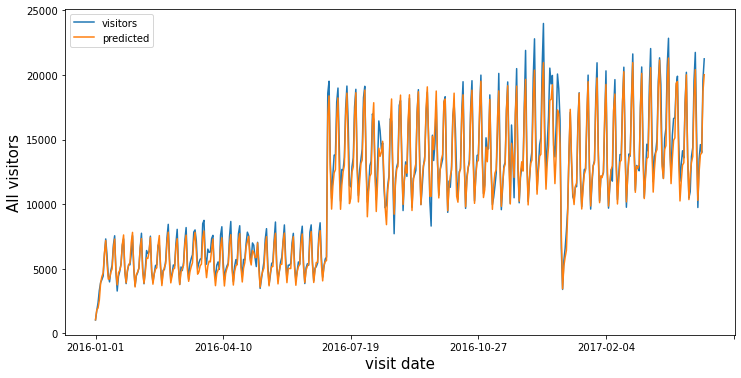

In [669]:
df = air_visit.drop('air_store_id', 1)
df['predicted'] = train_prediction

visitors_by_date = df.groupby(['visit_date']).agg({'visitors': np.sum})
visitors_by_date_pred = df.groupby(['visit_date']).agg({'predicted': np.sum})

fig,ax = plt.subplots(figsize=(12,6))
visitors_by_date.plot(kind='line', ax=ax)
visitors_by_date_pred.plot(kind='line', ax=ax)

plt.ylabel('All visitors',fontsize=15)
plt.xlabel('visit date',fontsize=15)
plt.show()

In [643]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
test_prediction = predict(test_eval_loader, model).numpy()



In [644]:
test_prediction.shape
test_prediction

array([-1.1772933 , -0.03851572,  0.2893226 , ..., -0.9120674 ,
       -0.8149916 , -0.8423617 ], dtype=float32)

In [645]:
test_prediction = test_prediction *  target_stdev + target_mean

In [655]:
test_prediction

array([ 1.2458477, 20.328352 , 25.821941 , ...,  5.69024  ,  7.3169403,
        6.8582993], dtype=float32)

In [653]:
test_prediction_exmp = np.expm1(test_prediction)
test_prediction_exmp = np.clip(test_prediction_exmp, a_min=1, a_max=None)
test_prediction_exmp = test_prediction_exmp.astype(int)

/var/folders/3f/t2z7k3f5209_6hp246wpbpg40000gn/T/ipykernel_43034/2809157971.py:1: RuntimeWarning: overflow encountered in expm1
  test_prediction_exmp = np.expm1(test_prediction)


In [656]:
test_prediction_exmp

array([           2,    673738048, 163804807168, ...,          294,
               1504,          950])

In [654]:
submission['visitors'] = test_prediction_exmp
submission.to_csv('sampleSubmission_lstm_with_exmp.csv', index=False)

In [ ]:


y = exp() - 1 